$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\braket}[2]{\langle #1 | #2 \rangle} $
$ \newcommand{\mat}[2]{\left( \begin{array}{#1} #2\end{array} \right)} $
$ \newcommand{\cvec}[1]{\mat{c}{#1}} $
$ \newcommand{\half}{\frac{1}{2}} $
$ \newcommand{\sqrthalf}{\frac{1}{\sqrt{2}}} $
$ \newcommand{\isqrthalf}{\frac{i}{\sqrt{2}}} $
$ \newcommand{\N}{\mathbb{N}} $
$ \newcommand{\R}{\mathbb{R}} $
$ \newcommand{\C}{\mathbb{C}} $
$ \newcommand{\hilb}{\mathscr{H}} $
<a href="https://courses.fit.cvut.cz/BI-QAP" target="_blank" align="left"><img src="images/CP_banner.png"  align="left"></a>

In [8]:
# import knihoven
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator, UnitarySimulator
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector, Operator

# Constrained Optimization By Linear Approximation optimizer
# nutno doinstalovat qiskit-algorithms 
from qiskit_algorithms.optimizers import COBYLA

import numpy as np
from numpy import pi, sqrt, exp
from numpy.linalg import norm
from numpy.random import rand
from matplotlib import pyplot as plt
np.set_printoptions(precision=5, suppress=True)
from scipy.linalg import eig

# užitečné funkce z minulých přednášek
def matrix(circuit):
    '''
    Funkce 'matrix(circuit)' vrátí unitární matici reprezentující kvantový obvod 'circuit'.
    Pozor, pokud hradlo nezná, je třeba obvod transpilovat.
    '''
    job = UnitarySimulator().run(circuit,shots=1,optimization_level=0)
    unitary = job.result().get_unitary(circuit).data
    return unitary

def statistics(circuit,rounds):
    '''
    Funkce 'statistics(circuit,rounds)' vrátí statistiku měření stavu kvantového obvodu 'circuit'. 'rounds' je počet měření.
    Pozor, pokud hradlo nezná, je třeba obvod transpilovat.
    '''
    job = AerSimulator().run(circuit,shots=rounds)
    counts = job.result().get_counts(circuit)
    return counts

# QAP 12 - Variační metody v kvantových výpočtech

## Variační charakterizace nejmenšího vlastního čísla (základní stav)

Podle jednoho z postulátů kvantové mechaniky každé pozorovatelné veličině kvantového systému odpovídá Hermitovský operátor na jistém Hilbertově prostoru.
Typicky půjde třeba o operátor popisující energetické stavy systému, tzv. Hamiltonián.

V kontextu kvantového počítání jsme se bavili o Hermitovských maticích $H$ na konečnědimenzionálním prostoru $\mathbb{C}^N$, tedy $N\times N$ maticích splňujících $H^\dagger = H$.
Nejprve udělejme malou odbočku zpět k Lineární algebře.

### Připomenutí diagonalizovatelnosti z Lineární algebry

Lze ukázat (v předmětu Lineární algebra na FITu se tomuto již nevěnujeme), že každá Hermitovská matice je diagonalizovatelná, tj. že

$$ P^{-1} H P = D, \quad \text{resp.} \quad H = P D P^{-1}, $$

kde $D$ je diagonální matice s vlastními čísly operátoru $H$ na diagonále a $P$ je regulární matice mající ve sloupcích popořadě vlastní vektory příslušející uvedeným vlastním číslům (v pořadí odpovídajícím pořadí vlastních čísel na diagonále matice $D$).

----
### Cvičení: K diagonalizaci a vlastním číslům/vektorům

 1. Ukažte, že vlastní vektory $\ket x$ a $\ket y$ Hermitovského operátoru $H$ příslušející různým vlastním číslům $\lambda$ a $\eta$ jsou kolmé, tj. $\braket x y = 0$.
 2. (Spíše připomenutí.) Vlastní čísla Hermitovské matice jsou reálná.
 3. Pro Hermitovskou $2 \times 2$ matici $H$ s vlastními čísly $\lambda$ a $\eta$ a odpovídajícími vlastními vektory $\ket x$ a $\ket y$ ukažte, že výše uvedený diagonalizační vztah $H = P D P^{-1}$ lze ekvialentně zapsat v bra-ketovém formalizu ve tvaru
 
$$ H = \lambda \ket x \bra x + \eta \ket y \bra y. $$

---

Třetí pozorování z předchozího cvičení platí zcela obecně.
Mějme Hermitovskou matici $H \in \mathbb{C}^{N,N}$, její (reálná!) vlastní čísla $\lambda_1 \leq \ldots \leq \lambda_N$ (mohou se opakovat dle násobnosti: tj. jednotková matice má vlastní čísla $\lambda_1 = \lambda_2 = \cdots = \lambda_N = 1$) a příslušné normalizované vlastní vektory $\ket{\psi_1}, \ldots, \ket{\psi_N}$ (dohromady tedy tvoří ortonormální soubor, $\braket{\psi_j}{\psi_k} = \delta_{j,k}$).
Pak je možné tuto matici diagonalizovat, resp. vyjádřit v následujícím tvaru:

$$ H = \sum_{i=1}^N \lambda_i \ket{\psi_i} \bra{\psi_i}. $$

Podle jednoho z dalších postulátů kvantové mechaniky je střední hodnota měření $H$ na stavu $\ket \psi$ (normalizovaný vektor!) rovna

$$ \langle H \rangle_\psi = \bra \psi H \ket \psi. $$

---

### Cvičení: Střední hodnota měření

Využijeme-li výše uvedený diagonalizovaný tvar $H$, pak pro střední hodnotu měření $H$ ve stavu $\ket \psi$ platí

$$ \langle H \rangle_\psi = \sum_{i=1}^N \lambda_i \big| \braket{\psi_i}{\psi} \big|^2. $$

Protože (**proč?**) pro každý stav $\ket \psi$ platí

$$ \sum_{i=1}^N \big| \braket{\psi_i}{\psi}\big|^2 = 1, $$

lze se na předchozí rovnost dívat jako na konvexní kombinaci vlastních čísel s vahami $|\braket{\psi_i}{\psi}|^2 \geq 0$ (vážený průměr).

---

Z předchozího cvičení plyne, že střední hodnota měření $H$ ve stavu $\ket\psi$ je omezena následujícími způsobem:

$$ \lambda_1 \leq \langle H \rangle_\psi \leq \lambda_N, $$

kde $\lambda_1$ (resp. $\lambda_N$) je nejmenší (resp. největší) vlastní číslo operátoru $H$ a rovnost nastává (mimo jiné) pro $\ket{\psi_1}$ (resp. $\ket{\psi_N}$).

Speciálně tedy platí

$$ \boxed{\lambda_1 = \min_{\substack{\ket \psi \in \mathbb{C}^N \\ \braket{\psi}{\psi} = 1}} \bra \psi H \ket \psi.} $$

O této poslední rovnosti se často mluví jako o **variační charakterizaci (variační metodě/variačním principu) nejnižší vlastní hodnoty matice $H$**.
Toto vlastní číslo typicky hledáme a předchozí rovnost nám k tomu dává možnost nalézt jeho horní odhad.
Pro nějaké zvolené normalizované $\ket \psi$ (tzv. **der Ansatz** - přístup, nastavení,...) platí

$$ \lambda_1 \leq \bra \psi H \ket \psi. $$

Měněním (variováním) hodnoty $\ket \psi$ se snažíme dostat k dolní mezi co nejblíže.
Jedná se o optimalizační úlohu, kde se snažíme volbou normalizovaného (kvadratické rovnostní omezení) vektoru z $\mathbb{C}^N$ minimalizovat hodnotu (kvadratické) objektivní funkce $\psi \mapsto \langle H \rangle_\psi$.

Matice $H$ může v praxi například odpovídat celkové energii kvantového systému (tzv. Hamiltonián) a nejnižší vlastní hodnota pak odpovídá energi "základního stavu" systému (například molekula).

---

## VQE: _Variational Quantum Eigensolver_

Obecná struktura kvantové variační metody (nemusí být nutně použita pouze na hledání nejmenšího vlastního čísla) je následující.

 1. Vytvoříme kvantový obvod parametrizovaný několika parametry (typicky méně než $N = 2^n$ pro $n$ qubitový systém), tzv. **variační formu**, který pro různé hodnoty parametrů vytváří různé Ansatzy.
 2. Při konkrétní volbě parametrů variační forma vytvoří stav $\ket \psi$, který dále použijeme k naměření hodnoty objektivní funkce (ve výše uvedeném příkladě střední hodnota $H$).
 3. Pomocí **klasického** optimalizačního algoritmu změníme parametry tak, abychom snížili hodnotu objektivní funkce (typicky nějaká variace gradientního sestupu).
 4. Opakujeme dokud uznáme za vhodné.

V následujícím textu tyto body dále rozebereme a poté ukážeme i konkrétní jednoduché příklady.

### Variační formy

V případě $n$-qubitového systémy bychom chtěli, abychom možnými výstupy variační formy pokryli celý stavový prostor $\mathbb{C}^N$, $N = 2^n$.
To očividně nebude prakticky možné kvůli "prokletí dimenzionality".
S rostoucím počtem qubitů bychom potřebovali exponenciálně rostoucí počet parametrů.

Pojďme se ale pro názornost zamyslet nad situací s **jedním qubitem** ($n = 1$).
Jako variační formu bychom mohli použít obecné $U$ hradlo závisející na třech parametrech $\theta, \phi, \lambda$:

$$ U(\theta, \phi, \lambda) = \begin{pmatrix} \cos(\theta/2) & -e^{i\lambda} \sin(\theta/2) \\ e^{i\phi} \sin(\theta/2) & e^{i\lambda +i\phi} \cos(\theta/2) \end{pmatrix}. $$

Pomocí tohoto hradla jsme schopni vytvořit libovolný stav z $\mathbb{C}^2$ (tedy až na celkovou nepodstatnou fázi).

V případě více qubitů se dá použít více možných přístupů, například:

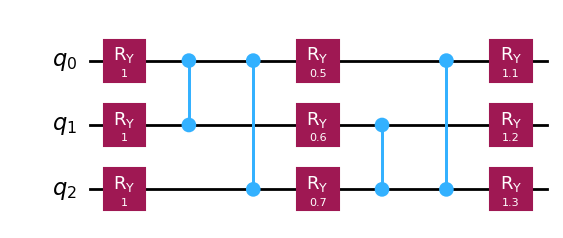

In [4]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [[1, 1, 1], [0.5, 0.6, 0.7], [1.1, 1.2, 1.3]])
circ.draw(output='mpl')

Rotace umožňují parametrizace, kontrolovaná $Z$ hradla pak zase zajišťují interferenci mezi qubity.
Není na škodu si variační formu představovat jako kvantový analog **neuronové sítě** s několika vrstvami.
V tomto "klasickém" příkladě máme možnost měnit parametry neuronů a síť definuje i spojení neuronů.

### Numerická optimalizace

Existuje více možností, či strategií, jak měnit parametry za účelem snížení hodnoty objektivní funkce.
V úvahu připadají různé varianty gradientního sestupu, například _Simultaneous Perturbation Stochastic Approximation_ [SPSA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html).
Tato metoda aproximuje gradient objektivní funkce na základě pouze dvou měření. Je doporučena pro použití na skutečném kvantovém hardware, kde se lépe vypořádává s přítomným šumem.

V qiskit je dále k dispozici algoritmus _Constrained Optimization by Linear Approximation_ [COBYLA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.COBYLA.html), který se hodí pro použití v ukázkách.
Zkusme pomocí něho pro ukázku nalézt minimum jisté kvadratické funkce dvou proměnných.

In [6]:
def func(xy):
    # Highly primitive logging
    print(xy)
    return 2 + (xy[0] - 1)**2 + 2 * (xy[1] + 3)**2

# Nastavení COBYLA
optimizer = COBYLA(maxiter = 500, tol = 0.0001)

# Výchozí bod (náhodně)
x0 = np.random.rand(2)

# Samotná optimalizace/minimalizace
result = optimizer.minimize(func, x0)

print("Minimal value:", result.fun)
print("Minimum at point:", result.x)

[0.89366 0.26096]
[1.89366 0.26096]
[0.89366 1.26096]
[ 0.8414  -0.73767]
[ 0.76995 -1.73511]
[ 0.17971 -2.54235]
[ 0.84009 -3.29328]
[ 0.6308  -3.74737]
[ 1.30017 -3.09752]
[ 1.21625 -2.86203]
[ 1.334   -2.82007]
[ 0.97176 -2.91423]
[ 0.72177 -2.91251]
[ 0.84677 -2.91337]
[ 0.97219 -2.85173]
[ 1.01669 -3.03087]
[ 0.90542 -3.08783]
[ 1.14039 -3.04883]
[ 1.07854 -3.03985]
[ 0.99668 -3.05488]
[ 1.0061  -3.00147]
[ 1.02466 -2.97633]
[ 0.99082 -2.99823]
[ 1.00488 -3.00919]
[ 1.00891 -2.99418]
[ 1.00751 -2.99783]
[ 1.00792 -3.00217]
[ 1.0022 -3.0015]
[ 1.00079 -2.99786]
[ 0.99857 -3.00296]
[ 1.00405 -3.00088]
[ 1.00129 -3.00188]
[ 1.00046 -3.00239]
[ 1.00148 -3.00233]
[ 1.00086 -3.00101]
[ 1.00039 -3.00015]
[ 0.99942 -3.00007]
[ 1.00052 -2.99918]
[ 1.0004  -3.00064]
[ 1.00043 -2.99991]
[ 1.00051 -3.00017]
[ 1.00015 -3.00011]
[ 0.99991 -3.00009]
[ 0.99984 -3.00032]
[ 0.99991 -2.99984]
[ 0.99984 -3.00016]
[ 0.99987 -3.00005]
[ 0.99993 -2.99998]
[ 0.99999 -2.9999 ]
Minimal value: 2.00000002105

Toto je očekávaný výsledek, minimum je očividně v bodě $(1, -3)$ a jeho hodnota je $2$.

### Hadamardův test

Při hledání nejmenšího vlastního čísla roli objektivní funkce (_cost function_) hraje střední hodnota.
Jak ji ale změřit?

Cílem Hadamardova testu je pro zadané hradlo (unitární matici) $U$ a vektor $\ket \psi$ získat střední hodnotu $\bra \psi U \ket \psi$.
Toho dosáhneme pomocí následujícího obvodu:

![Hadamard test](images/hadamard_test.png)

Pojďme si toto tvrzení rozmyslet:

 1. Systém je připraven ve stavu $\ket 0 \otimes \ket \psi$, vektor $\ket\psi$ jsme dostali z variační formy.
 2. Aplikací prvního Hadamardova hradla dostaneme systém do stavu $\frac{1}{\sqrt{2}} (\ket 0 + \ket 1) \otimes \ket\psi = \frac{1}{\sqrt{2}} \big( \ket0 \otimes \ket\psi + \ket1 \otimes \ket\psi \big)$.
 3. Po aplikaci hradla $U$ kontrolovaného prvním qubitem pak dostaneme systém do stavu $\frac{1}{\sqrt{2}} \big( \ket0 \otimes \ket\psi + \ket1 \otimes U\ket\psi \big)$.
 4. Druhé Hadamardovo hradlo na prvním qubitu pak má za následek přechod do stavu

$$ \frac{1}{2} \big( (\ket0 + \ket1) \otimes \ket\psi + (\ket0 - \ket1) \otimes U\ket\psi \big) = \frac{1}{2} \big( \ket0 \otimes ( I + U )\ket\psi + \ket1 \otimes ( I - U )\ket\psi \big). $$

 5. Provedeme měření _prvního qubitu_. Pravděpodobnost naměření $\ket 0$, ozn. $P(0)$, resp. $\ket 1$, ozn. $P(1)$, je

\begin{align*}
    P(0) &= \frac{1}{4} \bra\psi (I + U^\dagger) (I + U) \ket\psi = \frac{1}{4} \bra\psi (I + U^\dagger + U + U^\dagger U) \ket \psi = \\
    &= \frac{1}{4} ( 2 + \bra\psi U^\dagger \ket\psi + \bra\psi U \ket\psi) = \frac{1}{4} ( 2 + \overline{\bra\psi U \ket\psi} + \bra\psi U \ket\psi) = \\
    &= \frac{1}{2} (1 + \Re \bra\psi U \ket\psi), \\
    P(1) &= \cdots = \frac{1}{2} (1 - \Re \bra\psi U \ket\psi).
\end{align*}

Odtud plyne, že $P(0) - P(1) = \Re \bra\psi U \ket\psi$. Reálná část nás nemusí trápit, měřená hodnota bude typicky reálná.

---
### Cvičení: Nejmenší vlastní číslo Hadamardovy matice

Hadamardova matice je unitární a Hermitovská současně.
Na jednom qubitu nám tedy umožňuje snad nejjednodušší možnou ilustraci výše uvedeného postupu.
Najděme její nejmenší vlastní číslo a odpovídající vlastní vektor.

Následující obvod obsahuje tři části:

 1. Variační formu na 1. qubitu připravující Ansatz, zde $U$ hradlo.
 2. Hadamardův test využívající pomocný 0. qubit.
 3. Měření 0. qubitu z kterého získáme aproximaci hledané střední hodnoty.

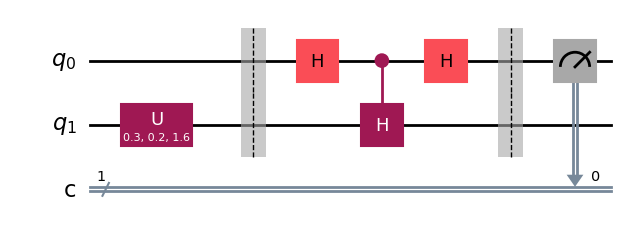

In [7]:
def vqe_circuit(params):
    qc = QuantumCircuit(2, 1)
    # Variační forma
    qc.u(params[0], params[1], params[2], 1)
    qc.barrier()
    
    # Hadamardův test
    qc.h(0)
    qc.ch(0, 1) # <- pozorovatelná, jejíž střední hodnotu měříme
    qc.h(0)
    qc.barrier()
    
    # Měření
    qc.measure(0, 0)
    
    return qc

vqe_circuit((0.3, 0.2, 1.6)).draw(output='mpl')

Nyní sestavíme objektivní funkci, tj. střední hodnotu měření $H$ na připraveném stavu, kterou dále budeme už klasicky minimalizovat.

In [9]:
def objective_function(params, nshots = 1000):
    qc = vqe_circuit(params)

    simulator = AerSimulator()
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots = nshots)
    counts = job.result().get_counts(qc_t)
    
    # P(0) - P(1), counts['0'] může selhat, proto metoda get s defaultní hodnotou
    expectation = (counts.get('0', 0) - counts.get('1', 0)) / nshots
    
    # Logging
    print(expectation)
    return expectation

Pokusné vyhodnocení.

In [10]:
objective_function([0.5, 0.4, 0.6])

0.934


0.934

K minimalizaci zvolíme algoritmus COBYLA, který je obsažen přímo v qiskitu.

In [11]:
optimizer = COBYLA(maxiter = 500, tol = 0.00001)
params = np.random.rand(3)
result = optimizer.minimize(objective_function, params)

print("Parameters:         ", result.x)
print("Minimal eigenvalue: ", result.fun)

0.738
0.182
-0.454
-0.478
-0.942
-0.928
-0.398
-0.948
-0.872
-0.886
-0.872
-0.964
-0.992
-0.98
-0.986
-0.98
-0.976
-0.996
-0.992
-0.986
-0.992
-0.978
-0.998
-1.0
-1.0
-0.994
-0.996
-0.998
-0.994
-1.0
-0.996
-0.998
-0.996
-0.996
-1.0
-0.994
-0.996
-0.996
-0.998
-0.996
-0.998
-0.994
-0.998
-0.996
-0.994
-0.992
-0.996
-1.0
-0.996
-0.996
-0.992
Parameters:          [2.43815 3.14989 2.13912]
Minimal eigenvalue:  -0.992


Vidíme, že jsme se dostali blízko očekávané hodnotě ($-1$).
Vlastní vektor zkontrolujeme jednoduše tak, že variační formu použijeme s našimi optimálními parametry: 

In [14]:
qc = QuantumCircuit(1)
qc.u(params[0], params[1], params[2], 0)

state = Statevector.from_instruction(qc).data
state

array([0.90529+0.j     , 0.2398 +0.35063j])

Ano, skutečně se jedná o jeden z možných vlastních vektorů příslušejících $-1$ (druhý sloupec, celkové znaménko může být jiné):

In [13]:
Hmat = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
eig(Hmat)

(array([ 1.+0.j, -1.+0.j]),
 array([[ 0.92388, -0.38268],
        [ 0.38268,  0.92388]]))

---
### Cvičení: Nejmenší vlastní číslo neunitární Hermitovské matice

V předchozím příkladě byla podstatná unitarita Hadamardovy matice.
Co když naše hermitovská matice není unitární?
Lze ukázat, že každou hermitovskou matici lze napsat jako lineární kombinaci čtyř unitárních matic.
U matic $2 \times 2$ to lze udělat i explicitně pomocí Pauliho matic (ty známe jako jedno-qubitová hradla $X$, $Y$ a $Z$).
Obecný tvar $2 \times 2$ hermitovské matice je

$$
 H = \alpha \underbrace{\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}}_{I} + \beta \underbrace{\begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}}_{Z}
+ \gamma \underbrace{\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}}_{X} + \delta \underbrace{\begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}}_{Y},
$$

kde $\alpha,\beta,\gamma,\delta$ jsou reálné konstanty. Pro Ansatz $\ket \psi$ pak máme střední hodnotu $H$ rovnu (nezapomeňte, že $\braket{\psi}{\psi} = 1$)

$$
\langle H \rangle_\psi = \alpha + \beta \bra \psi Z \ket \psi + \gamma \bra \psi X \ket \psi + \delta \bra \psi Y \ket \psi.
$$


Pojďme situaci prozkoumat pro hodnoty koeficientů $\alpha = 1$, $\beta = 2$, $\gamma = 3$ a $\delta = 2$, tj. pro matici

$$
    H = \begin{pmatrix} 3 & 3-2i \\ 3+2i & -1 \end{pmatrix}.
$$

Vytvoříme si obvody pro Hadamardův test, tj. měření středních hodnot $\bra \psi X \ket \psi$, $\bra \psi Y \ket \psi$ a $\bra \psi Z \ket \psi$ pro Ansatz $\ket \psi$.
Nezapomeňte, že $X$, $Y$ i $Z$ jsou unitární i hermitovské současně.

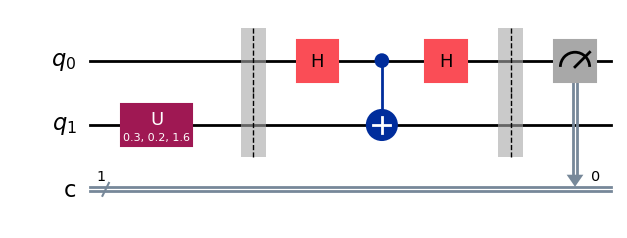

In [15]:
def vqe_circuit_X(params):
    qc = QuantumCircuit(2, 1)
    qc.u(params[0], params[1], params[2], 1)
    qc.barrier()
    qc.h(0)
    qc.cx(0, 1)
    qc.h(0)
    qc.barrier()
    qc.measure(0, 0)
    
    return qc

vqe_circuit_X((0.3, 0.2, 1.6)).draw(output='mpl')

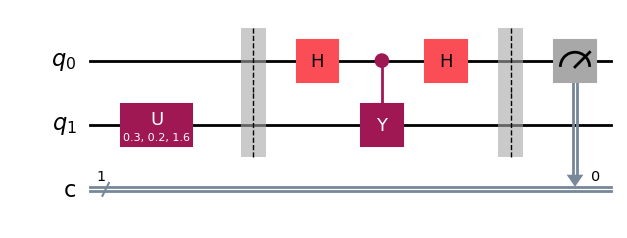

In [16]:
def vqe_circuit_Y(params):
    qc = QuantumCircuit(2, 1)
    qc.u(params[0], params[1], params[2], 1)
    qc.barrier()
    qc.h(0)
    qc.cy(0, 1)
    qc.h(0)
    qc.barrier()
    qc.measure(0, 0)
    
    return qc

vqe_circuit_Y((0.3, 0.2, 1.6)).draw(output='mpl')

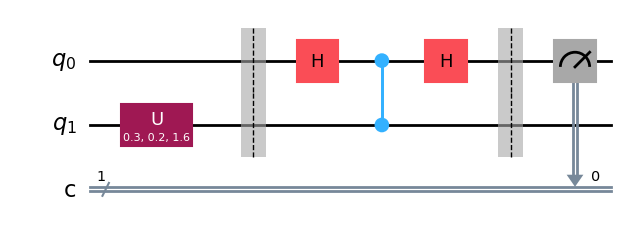

In [17]:
def vqe_circuit_Z(params):
    qc = QuantumCircuit(2, 1)
    qc.u(params[0], params[1], params[2], 1)
    qc.barrier()
    qc.h(0)
    qc.cz(0, 1)
    qc.h(0)
    qc.barrier()
    qc.measure(0, 0)
    
    return qc

vqe_circuit_Z((0.3, 0.2, 1.6)).draw(output='mpl')

Naše objektivní funkce nyní naměří všechny čtyři střední hodnoty a sestaví střední hodnotu $\bra \psi H \ket \psi$ pro Ansatz $\ket \psi$.

In [18]:
def objective_function(params, coeffs = (1, 2, 3, 2), nshots = 50000):
    simulator = AerSimulator()
    
    qc = vqe_circuit_X(params)
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots = nshots)
    counts = job.result().get_counts(qc_t)
    expectation_X = (counts.get('0', 0) - counts.get('1', 0)) / nshots
    
    qc = vqe_circuit_Y(params)
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots = nshots)
    counts = job.result().get_counts(qc_t)
    expectation_Y = (counts.get('0', 0) - counts.get('1', 0)) / nshots
    
    qc = vqe_circuit_Z(params)
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots = nshots)
    counts = job.result().get_counts(qc_t)
    expectation_Z = (counts.get('0', 0) - counts.get('1', 0)) / nshots
    
    expectation = coeffs[0] + coeffs[1] * expectation_Z + coeffs[2] * expectation_X + coeffs[3] * expectation_Y
    
    # Logging
    print(expectation)
    return expectation

Pokusné vyhodnocení:

In [19]:
objective_function([0.1, 0.5, 0.7])

3.3654


3.3654

Nyní spustíme výpočet, k optimalizaci opět použijeme COBYLA.

In [20]:
optimizer = COBYLA(maxiter = 500, tol = 0.0001)
params = np.random.rand(3)
result = optimizer.minimize(objective_function, params)

print("Parameters:         ", result.x)
print("Minimal eigenvalue: ", result.fun)

4.8250399999999996
3.2496799999999997
3.01064
3.01592
-0.4638399999999999
-2.21868
0.0460799999999999
-2.7199999999999998
-2.85364
-2.1808
-2.71244
-3.00472
-3.07512
-3.0636799999999997
-2.90196
-2.7453200000000004
-3.0842
-3.08004
-3.11796
-3.07348
-3.08468
-3.09764
-3.1047599999999997
-3.1347200000000006
-3.10228
-3.12912
-3.12772
-3.14708
-3.12204
-3.13244
-3.12172
-3.10976
-3.12856
-3.1291599999999997
-3.1298
-3.1156800000000002
-3.09428
-3.1272
-3.13964
-3.11184
-3.09452
-3.1274399999999996
-3.12008
-3.1382000000000003
-3.1171600000000006
-3.12472
-3.15272
-3.1231199999999997
Parameters:          [4.18627 0.5638  1.08228]
Minimal eigenvalue:  -3.1231199999999997


In [21]:
qc = QuantumCircuit(1)
qc.u(params[0], params[1], params[2], 0)

state = Statevector.from_instruction(qc).data
state

array([0.88512+0.j     , 0.4596 +0.07303j])

In [22]:
Hmat = np.array([[3, 3-2j], [3+2j, -1]])
eig(Hmat)

(array([ 5.12311+0.j, -3.12311+0.j]),
 array([[ 0.86171+0.j     , -0.42219+0.28146j],
        [ 0.42219+0.28146j,  0.86171+0.j     ]]))

Shoda zde už možná není tolik uspokojivá, můžete zkusit další hodnoty parametrů.

## Dodatek: Řešení soustav lineárních rovnic variačními metodami na kvantovém počítači

V tomto dodatku si ukážeme, z ptačí perspektivy, jak využít variační metodu k řešení soustavy lineárních rovnic.

Je zadána matice $A$ a normalizovaný vektor $\ket b$ a cílem je nalézt vektor $\ket x$ splňující $A \ket x = \ket b$, resp. až na normalizaci vektoru $\ket x$.

**Vstupem algoritmu** je matice $A$ ve formě rozkladu na unitární matice,

$$ A = \sum_n c_n A_n $$

a hradlo $U$, které vytvoří zadaný stav $\ket b$, $U \ket0 = \ket b$.

Zvolíme Ansatz $\ket{\psi(k)}$ kontrolovaný sadou parametrů $k$ (parametrizované hradlo $V(k)$).
Naším cílem je nalézt parametry $k$ tak, aby $\ket\Phi := A \ket{\psi(k)}$ byl "blízko" vektoru $\ket b$, aby byly takřka kolineární.
Toho můžeme dosáhnout například následující objektivní funkcí (_cost function_):

$$ \ket\Phi \mapsto 1 - \frac{|\braket b \Phi|^2}{ \braket \Phi \Phi}. $$

Všimněte si, že (Schwartzova nerovnost)

$$ 0 \leq \frac{|\braket b \Phi|^2}{ \braket \Phi \Phi} \leq \frac{\|\ket b\|^2 \|\ket \Phi\|^2}{\|\ket \Phi\|^2} = 1 $$

a

$$ 1 - \frac{|\braket{b}{cb}|^2}{ \braket{cb}{cb}} = 0. $$

Takže daná funkce nabývá v požadovaném případě minima s hodnotou $0$.

K výpočtu hodnot $\braket b \Phi$ a $\braket \Phi \Phi$ nyní můžeme použít opět Hadamardův test. Připomeňme, že $A$ máme zadánu jako lineární kombinaci unitárních matic $A_n$ s danými koeficienty $c_n$ a $\Phi = A \ket{\psi(k)} = A V(k) \ket{0}$, $\ket b = U \ket0$. Proto máme

$$ \braket\Phi\Phi = \bra0 V(k)^\dagger A^\dagger A V(k) \ket0 = \sum_{m,n} \overline{c_m} c_n \bra0 V(k)^\dagger A_m^\dagger A_n V(k) \ket0. $$

Hodnoty $\bra0 V(k)^\dagger A_m^\dagger A_n V(k) \ket0$ umíme určit pomocí Hadamardova testu pro všechna $m,n$.

Podobně se vypořádáme s druhým členem v objektivní funkci, konkrétně

$$ \braket b \Phi = \bra0 U^\dagger A V(k) \ket0 = \sum_n c_n \bra0 U^\dagger A_n V(k) \ket0. $$

Je tedy nutné naměřit $\bra0 U^\dagger A_n V(k) \ket0$ pro všechna $n$.

Qiskit implementace je už poměrně náročná a proto ji na tomto místě vynecháváme. Zájemce můžeme odkázat do [Qiskit textbook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/vqls.ipynb).